In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
import lightgbm as lgb
from tqdm import tqdm_notebook
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import multiprocessing
from sklearn.model_selection import StratifiedKFold,TimeSeriesSplit

import gc


In [2]:
def sd(col, max_loss_limit=0.001, avg_loss_limit=0.001, na_loss_limit=0, n_uniq_loss_limit=0, fillna=0):
    """
    max_loss_limit - don't allow any float to lose precision more than this value. Any values are ok for GBT algorithms as long as you don't unique values.
                     See https://en.wikipedia.org/wiki/Half-precision_floating-point_format#Precision_limitations_on_decimal_values_in_[0,_1]
    avg_loss_limit - same but calculates avg throughout the series.
    na_loss_limit - not really useful.
    n_uniq_loss_limit - very important parameter. If you have a float field with very high cardinality you can set this value to something like n_records * 0.01 in order to allow some field relaxing.
    """
    is_float = str(col.dtypes)[:5] == 'float'
    na_count = col.isna().sum()
    n_uniq = col.nunique(dropna=False)
    try_types = ['float16', 'float32']

    if na_count <= na_loss_limit:
        try_types = ['int8', 'int16', 'float16', 'int32', 'float32']

    for type in try_types:
        col_tmp = col

        # float to int conversion => try to round to minimize casting error
        if is_float and (str(type)[:3] == 'int'):
            col_tmp = col_tmp.copy().fillna(fillna).round()

        col_tmp = col_tmp.astype(type)
        max_loss = (col_tmp - col).abs().max()
        avg_loss = (col_tmp - col).abs().mean()
        na_loss = np.abs(na_count - col_tmp.isna().sum())
        n_uniq_loss = np.abs(n_uniq - col_tmp.nunique(dropna=False))

        if max_loss <= max_loss_limit and avg_loss <= avg_loss_limit and na_loss <= na_loss_limit and n_uniq_loss <= n_uniq_loss_limit:
            return col_tmp

    # field can't be converted
    return col


def reduce_mem_usage_sd(df, deep=True, verbose=False, obj_to_cat=False):
    numerics = ['int16', 'uint16', 'int32', 'uint32', 'int64', 'uint64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    for col in tqdm_notebook(df.columns):
        col_type = df[col].dtypes

        # collect stats
        na_count = df[col].isna().sum()
        n_uniq = df[col].nunique(dropna=False)
        
        # numerics
        if col_type in numerics:
            df[col] = sd(df[col])

        # strings
        if (col_type == 'object') and obj_to_cat:
            df[col] = df[col].astype('category')
        
        if verbose:
            print(f'Column {col}: {col_type} -> {df[col].dtypes}, na_count={na_count}, n_uniq={n_uniq}')
        new_na_count = df[col].isna().sum()
        if (na_count != new_na_count):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost na values. Before: {na_count}, after: {new_na_count}')
        new_n_uniq = df[col].nunique(dropna=False)
        if (n_uniq != new_n_uniq):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost unique values. Before: {n_uniq}, after: {new_n_uniq}')

    end_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df


In [3]:
path='../input/ieee-fraud-detection/'
print('Train readed\n')
train_identity = pd.read_csv(f'{path}train_identity.csv')
train_transaction = pd.read_csv(f'{path}train_transaction.csv')
print('Test readed\n')
test_identity = pd.read_csv(f'{path}test_identity.csv')
test_transaction = pd.read_csv(f'{path}test_transaction.csv')
print('Merging\n')
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
del train_identity,train_transaction,test_identity,test_transaction
gc.collect()

train = reduce_mem_usage_sd(train, obj_to_cat=False)

gc.collect()

one_value_cols = [col for col in train.columns if train[col].nunique() <= 1]
one_value_cols_test = [col for col in test.columns if test[col].nunique() <= 1]

cols_to_drop =['id_22', 'id_27', 'id_08', 'dist2', 'id_07', 'id_21', 'id_24', 'id_25', 'id_18', 'id_26', 'D7']

cols_to_drop = list(set(one_value_cols+ one_value_cols_test+cols_to_drop))
train = train.sort_values('TransactionDT').drop(cols_to_drop, axis=1)
del test
gc.collect()
Cat= ['ProductCD']+['card'+str(x) for x in range(1,7)]+['addr1','addr2','P_emaildomain','R_emaildomain']+['M'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(12,39)]+['DeviceType','DeviceInfo']
Cat=[col for col in Cat if (col not in cols_to_drop)]
ToDel = ['isFraud', 'TransactionDT', 'TransactionID']
Num=[item for item in train.columns.values.tolist() if (item not in Cat+ToDel+cols_to_drop)]


Train readed

Test readed

Merging




Mem. usage decreased from 2598.36 Mb to 1327.81 Mb (48.9% reduction)


In [4]:
for f in tqdm_notebook(Cat):
  le = LabelEncoder()
  mis_pos = train[f].isnull().tolist()
  le.fit(list(train[f].astype(str).values))
  train[f] = le.transform(list(train[f].astype(str).values))
  feat_mask = [cats==(f) for cats in [x for x in train.columns]]
  train.iloc[mis_pos,feat_mask] = np.nan

gc.collect()
train = reduce_mem_usage_sd(train)
X = train.sort_values('TransactionDT').drop(ToDel, axis=1)
y = train.sort_values('TransactionDT')['isFraud']

del train
gc.collect()
X.fillna(-999, inplace=True)



Mem. usage decreased from 711.86 Mb to 569.38 Mb (20.0% reduction)


In [5]:
seed=1
params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'feature_fraction': 0.44301599784064954,
                    'lambda_l1': 0.7185712774952702,
                    'lambda_l2': 0.8036657945008269,
                    'learning_rate': 0.006820638087926107,
                    'min_data_in_leaf': int(122.18518093103775),
                    'min_gain_to_split': 0.8732382864345388,
                    'min_sum_hessian_in_leaf': 0.009332742523926576,
                    'num_leaves': int(274.4907722765963),
                    'max_depth': int(30.889651140632285),
                    'tree_learner':'serial',
                    'max_bin':255,
                    'seed': seed,
                }

idxs = np.arange(X.shape[0])
cv_splits = [(idxs[:350000], idxs[400000:])]

In [6]:
# def stupid_iter():
#     for col in [0]:
#         yield([(idxs[:350000], idxs[400000:])])
# cv_splits = stupid_iter()


In [7]:
fold = TimeSeriesSplit(5)
# for tr,tra in fold.split(X,y):
#     print(tra)

In [8]:
clf = lgb.LGBMClassifier(**params)
rfe = RFECV(estimator=clf, step=15, cv=fold, scoring='roc_auc', verbose=2)
rfe.fit(X, y)


Fitting estimator with 419 features.
Fitting estimator with 404 features.
Fitting estimator with 389 features.
Fitting estimator with 374 features.
Fitting estimator with 359 features.
Fitting estimator with 344 features.
Fitting estimator with 329 features.
Fitting estimator with 314 features.
Fitting estimator with 299 features.
Fitting estimator with 284 features.
Fitting estimator with 269 features.
Fitting estimator with 254 features.
Fitting estimator with 239 features.
Fitting estimator with 224 features.
Fitting estimator with 209 features.
Fitting estimator with 194 features.
Fitting estimator with 179 features.
Fitting estimator with 164 features.
Fitting estimator with 149 features.
Fitting estimator with 134 features.
Fitting estimator with 119 features.
Fitting estimator with 104 features.
Fitting estimator with 89 features.
Fitting estimator with 74 features.
Fitting estimator with 59 features.
Fitting estimator with 44 features.
Fitting estimator with 29 features.
Fittin

RFECV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
      estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                               colsample_bytree=1.0,
                               feature_fraction=0.44301599784064954,
                               importance_type='split',
                               lambda_l1=0.7185712774952702,
                               lambda_l2=0.8036657945008269,
                               learning_rate=0.006820638087926107, max_bin=255,
                               max_depth=30, metric='auc', min_child_sample...
                               min_gain_to_split=0.8732382864345388,
                               min_split_gain=0.0,
                               min_sum_hessian_in_leaf=0.009332742523926576,
                               n_estimators=100, n_jobs=-1, num_leaves=274,
                               objective='binary', random_state=None,
                               reg_alpha=0.0, reg_lambda=0.0, seed=

In [9]:
print('Optimal number of features:', rfe.n_features_)


Optimal number of features: 164


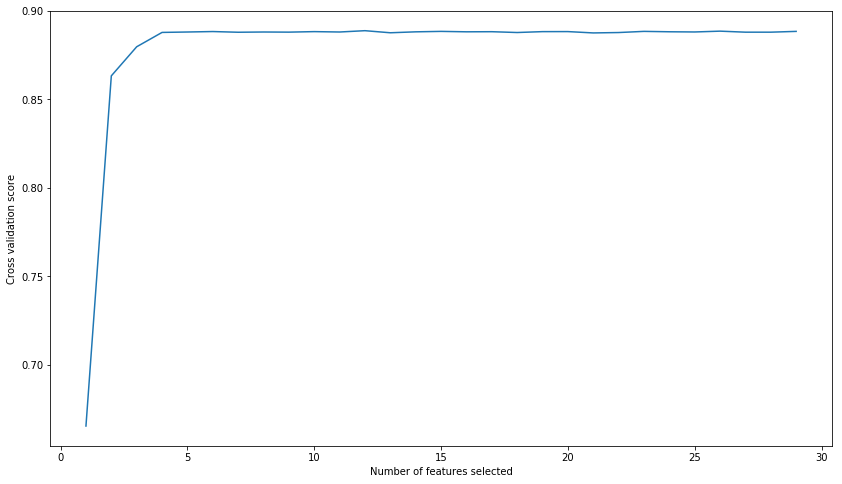

In [10]:
plt.figure(figsize=(14, 8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()


In [11]:
for col in X.columns[rfe.ranking_ == 1]:
    print(col)
Name=[col for col in X.columns[rfe.ranking_==1]]
pd.DataFrame(Name,columns=['Name']).to_csv('feature_selection.csv', index=False)


TransactionAmt
ProductCD
card1
card2
card3
card4
card5
card6
addr1
addr2
dist1
P_emaildomain
R_emaildomain
C1
C2
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
D1
D2
D3
D4
D5
D6
D8
D9
D10
D11
D12
D13
D14
D15
M3
M4
M5
M6
V5
V12
V13
V19
V20
V24
V29
V35
V36
V38
V44
V45
V47
V53
V54
V55
V56
V58
V61
V62
V67
V70
V75
V76
V77
V78
V82
V83
V86
V87
V90
V91
V96
V99
V102
V124
V127
V128
V129
V130
V131
V133
V134
V136
V143
V149
V156
V160
V162
V165
V170
V187
V189
V201
V207
V209
V210
V212
V217
V225
V234
V251
V257
V258
V261
V264
V266
V268
V271
V274
V277
V279
V280
V281
V282
V283
V285
V287
V289
V291
V294
V296
V298
V306
V307
V308
V309
V310
V311
V312
V313
V314
V315
V316
V317
V318
V320
V321
V323
V324
V332
V333
id_01
id_02
id_03
id_05
id_06
id_09
id_13
id_14
id_17
id_19
id_20
id_30
id_31
id_32
id_33
id_38
DeviceType
DeviceInfo
